In [1]:
import os
import tarfile
import requests
import shutil
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from random import sample
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:

def select_data_subset(split_file, source_dir, target_dir, selected_classes, images_per_class=None):
    """
    Select specific classes and copy their images to a new directory for train/test splits.
    """
    os.makedirs(target_dir, exist_ok=True)

    # Read the split file (train.txt or test.txt)
    with open(split_file, 'r') as f:
        all_images = f.read().splitlines()

    # Filter images for the selected classes
    class_images = {cls: [] for cls in selected_classes}
    for img in all_images:
        cls = img.split('/')[0]
        if cls in selected_classes:
            class_images[cls].append(img)

    # Copy images for each selected class
    for cls, images in class_images.items():
        tgt_class_path = os.path.join(target_dir, cls)
        os.makedirs(tgt_class_path, exist_ok=True)

        if images_per_class:
            images = sample(images, images_per_class)

        for img in images:
            src_path = os.path.join(source_dir, f"{img}.jpg")
            tgt_path = os.path.join(tgt_class_path, os.path.basename(img) + ".jpg")
            shutil.copy(src_path, tgt_path)

In [3]:
dataset_path = "data101/food-101"

In [4]:
# # Step 2: Subset the Dataset for Training and Testing
# source_data_dir = os.path.join(dataset_path, "food-101", "images")
# train_split_file = os.path.join(dataset_path, "food-101", "meta", "train.txt")
# test_split_file = os.path.join(dataset_path, "food-101", "meta", "test.txt")

# subset_data_dir = "data25/food-101-25classes"

# # Choose 25 classes
# selected_classes = [
#     'poutine', 'grilled_salmon', 'hummus', 'fish_and_chips', 'beignets', 
#     'club_sandwich', 'spaghetti_carbonara', 'apple_pie', 'pizza', 'ceviche', 
#     'ravioli', 'nachos', 'french_fries', 'caesar_salad', 'takoyaki', 
#     'hot_dog', 'pho', 'scallops', 'shrimp_and_grits', 'risotto', 
#     'gyoza', 'deviled_eggs', 'french_onion_soup', 'macarons', 'churros'
# ]

# # Select data for training (750 images/class by default in Food-101)
# select_data_subset(train_split_file, source_data_dir, os.path.join(subset_data_dir, "train"), selected_classes)

# # Select data for testing (250 images/class by default in Food-101)
# select_data_subset(test_split_file, source_data_dir, os.path.join(subset_data_dir, "test"), selected_classes)

In [5]:

subset_data_dir = "data25/food-101-25classes"

In [6]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [7]:
# data augmentation
# create a train transformation

train_transform = transforms.Compose([
    # resize the image to 224X224
    transforms.Resize(size=(224, 224)),
    
    # flip the image randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    
    #transforms.RandomRotation(10),
    # #transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    # resize the image to 224X224
    transforms.Resize(size=(224, 224)),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])

In [8]:
subset_data_dir

'data25/food-101-25classes'

In [9]:
train_dataset = datasets.ImageFolder(root=os.path.join(subset_data_dir, "train"), 
                                    transform=train_transform)

test_dataset = datasets.ImageFolder(root=os.path.join(subset_data_dir, "test"), 
                                    transform=test_transform)

In [10]:
len(train_dataset), len(test_dataset)

(18750, 6250)

In [11]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# setup the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
len(train_dataset.classes)

25

In [14]:
len(train_loader), len(test_loader)

(586, 196)

In [15]:
from typing import Type, Any, Callable, List, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class BasicBlock(nn.Module):
    expansion: int = 1  # Class-level attribute for block expansion

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to handle downsampling or mismatched channels
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += shortcut
        return F.relu(x)


In [17]:
class ResNet(nn.Module):
    def __init__(self, 
                block: Type[BasicBlock], 
                num_blocks: List[int], 
                num_classes: int = 25) -> None:
        
        super().__init__()
        self.in_channels: int = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual block layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, 
                    block: Type[BasicBlock], 
                    out_channels: int, 
                    num_blocks: int, 
                    stride: int) -> nn.Sequential:
        
        layers: List[nn.Module] = []
        # First block with downsampling (if stride > 1)
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        # Remaining blocks
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten for the fully connected layer
        x = self.fc(x)
        return x

In [18]:
def ResNet18(num_classes: int = len(train_dataset.classes)) -> ResNet:
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

model = ResNet18(num_classes=len(train_dataset.classes)).to(device=device)

In [19]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
        BasicBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
       BasicBlock-14           [-1, 64,

In [20]:
from torchinfo import summary

summary(model, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 25]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Sequential: 3-1              [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-2                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-3             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    └─BasicBlock: 2-2                   [1, 64, 56, 56]           --
│

In [22]:
# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience: int = 3, verbose: bool = True):
        """
        Args:
            patience (int): Number of epochs to wait for improvement before stopping.
            verbose (bool): Print messages when stopping if True.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss: float):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered!")

In [23]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [24]:
def train_step(model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            accuracy_fn,
            train_loss_accum: list,
            train_acc_accum: list,
            device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logit = model(X)
        y_proba = torch.softmax(y_logit, dim=1)
        y_pred = y_proba.argmax(dim=1)

        # 2. Calculate loss
        loss = loss_fn(y_logit, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred)  # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_loss_accum.append(train_loss.item())
    train_acc_accum.append(train_acc / 100.0)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
            model: torch.nn.Module,
            loss_fn: torch.nn.Module,
            accuracy_fn,
            test_loss_accum: list,
            test_acc_accum: list,
            device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # put model in eval mode

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_logit = model(X)
            test_proba = torch.softmax(test_logit, dim=1)
            test_pred = test_proba.argmax(dim=1)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_logit, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)  # Go from logits -> pred labels
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_loss_accum.append(test_loss.item())
        test_acc_accum.append(test_acc / 100.0)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [25]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    
    return total_time

In [26]:
# Measure time
from tqdm.auto import tqdm  # type: ignore
from timeit import default_timer as timer

train_time_start_model = timer()

model = ResNet18(num_classes=len(train_dataset.classes)).to(device=device)

# Train and test model 
epochs = 20

# List to store train and test loss, accuracy
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Setup loss, optimizer, and learning rate scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), betas=(0.9, 0.999), lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2, verbose=True)

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=7, verbose=True)

for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n---------")
        
        train_step(data_loader=train_loader, 
                model=model, 
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn,
                train_loss_accum=train_losses,
                train_acc_accum=train_accuracies,
                device=device
                )
        
        test_step(data_loader=test_loader,
                model=model,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                test_loss_accum=test_losses,
                test_acc_accum=test_accuracies,
                device=device)
        
        # Update learning rate scheduler
        scheduler.step(test_losses[-1])  # Use the latest test loss
        
        # Check for early stopping
        early_stopping(val_loss=test_losses[-1])
        if early_stopping.early_stop:
                print("Stopping training early due to no improvement in test loss.")
                break

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                        end=train_time_end_model,
                                        device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.75727 | Train accuracy: 19.28%
Test loss: 2.50945 | Test accuracy: 26.83%

Epoch: 1
---------
Train loss: 2.73916 | Train accuracy: 19.65%
Test loss: 2.37236 | Test accuracy: 29.88%

Epoch: 2
---------
Train loss: 2.43071 | Train accuracy: 28.32%
Test loss: 2.36556 | Test accuracy: 31.29%

Epoch: 3
---------
Train loss: 2.22648 | Train accuracy: 33.73%
Test loss: 2.08650 | Test accuracy: 37.68%

Epoch: 4
---------
Train loss: 2.03075 | Train accuracy: 39.36%
Test loss: 1.89946 | Test accuracy: 43.41%

Epoch: 5
---------
Train loss: 1.84975 | Train accuracy: 44.96%
Test loss: 1.86465 | Test accuracy: 43.58%

Epoch: 6
---------
Train loss: 1.68556 | Train accuracy: 49.28%
Test loss: 1.72423 | Test accuracy: 48.70%

Epoch: 7
---------
Train loss: 1.55413 | Train accuracy: 53.25%
Test loss: 1.52838 | Test accuracy: 53.45%

Epoch: 8
---------
Train loss: 1.39056 | Train accuracy: 57.59%
Test loss: 1.46862 | Test accuracy: 55.92%

Epoch: 9
---------
Train los

In [27]:
from utils import plot_training_history_updated

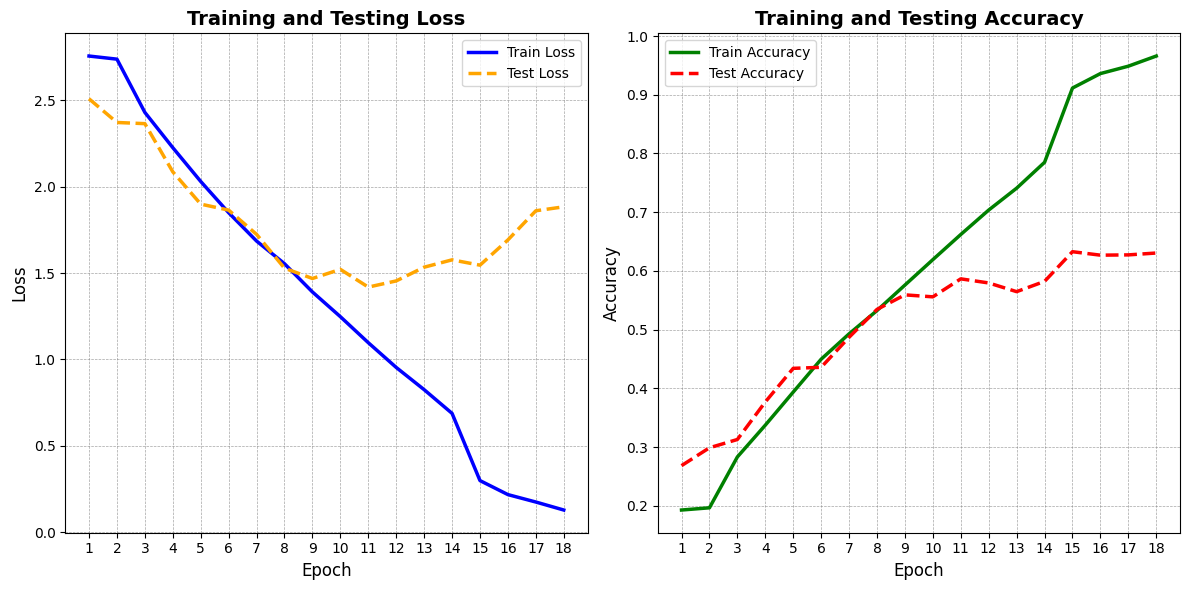

In [28]:
plot_training_history_updated(
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)